In [12]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Sequential
from keras.src.layers import Dense
from keras.src.layers import Flatten
from keras.utils import to_categorical
from mlxtend.evaluate import accuracy_score
from tensorflow import keras

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [4]:
X_train_full.dtype

dtype('uint8')

* Podzielmy pełny zestaw treningowy na zestaw walidacyjny i zestaw treningowy. 
* Kolor pikseli skalujemy również do zakresu 0-1 i przekształcamy na zmiennoprzecinkowe, dzieląc przez 255.

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

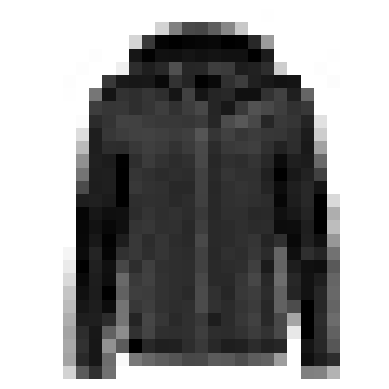

In [6]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [7]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Będziemy używać klas numerycznych i nazw.

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Coat'

Możemy narysować więcej przykładów treningowych.

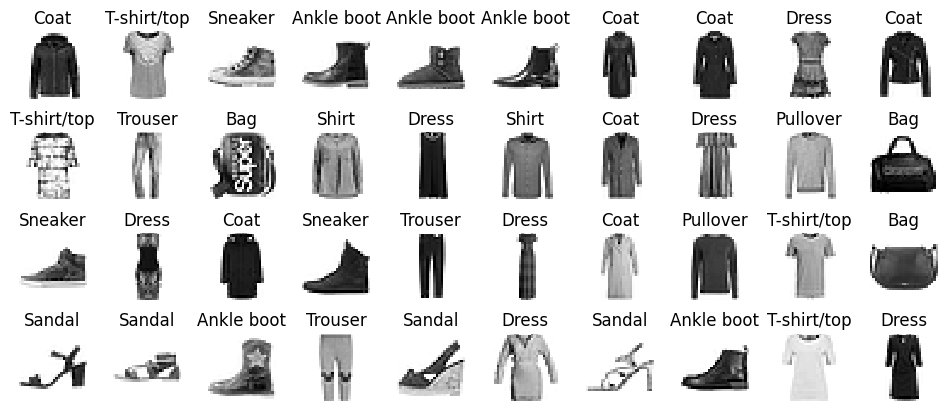

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Zad
Porównaj wyniki działań różnych optymalizacji
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
```
```python
Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```
```python
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```
https://keras.io/optimizers/

In [10]:
optimizers_names = [
    "SGD",
    "Adam 0.001",
    "Adam 0.0001"
]

/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
2024-06-07 04:49:29.542581: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [18]:
models_history = []

for i in range(len(optimizers_names)):
    if optimizers_names[i] == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizers_names[i] == "Adam 0.001":
        optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    elif optimizers_names[i] == "Adam 0.0001":
        optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))  # Flatten images
    model.add(Dense(300, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=32, epochs=30,
                        verbose=0)
    models_history.append((history, model))
    print(f"finished {optimizers_names[i]}")

/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


finished SGD
finished Adam 0.001
finished Adam 0.0001


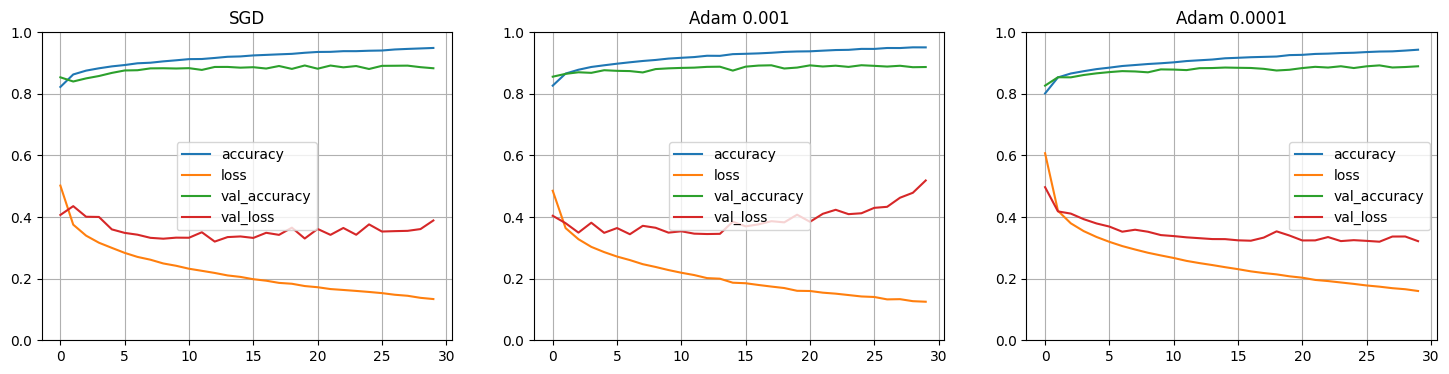

In [19]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))

axs = axs.flatten()

for i, (history, model) in enumerate(models_history):
    pd.DataFrame(history.history).plot(ax=axs[i])
    axs[i].set_title(optimizers_names[i])
    axs[i].set_ylim(0, 1)
    axs[i].grid(True)
    axs[i].legend()

In [22]:
df = pd.DataFrame(columns=["optimizer", "accuracy"])

for i, (history, model) in enumerate(models_history):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    df.loc[i] = [optimizers_names[i], accuracy]

df

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


,optimizer,accuracy
0,SGD,0.8832
1,Adam 0.001,0.8872
2,Adam 0.0001,0.8896


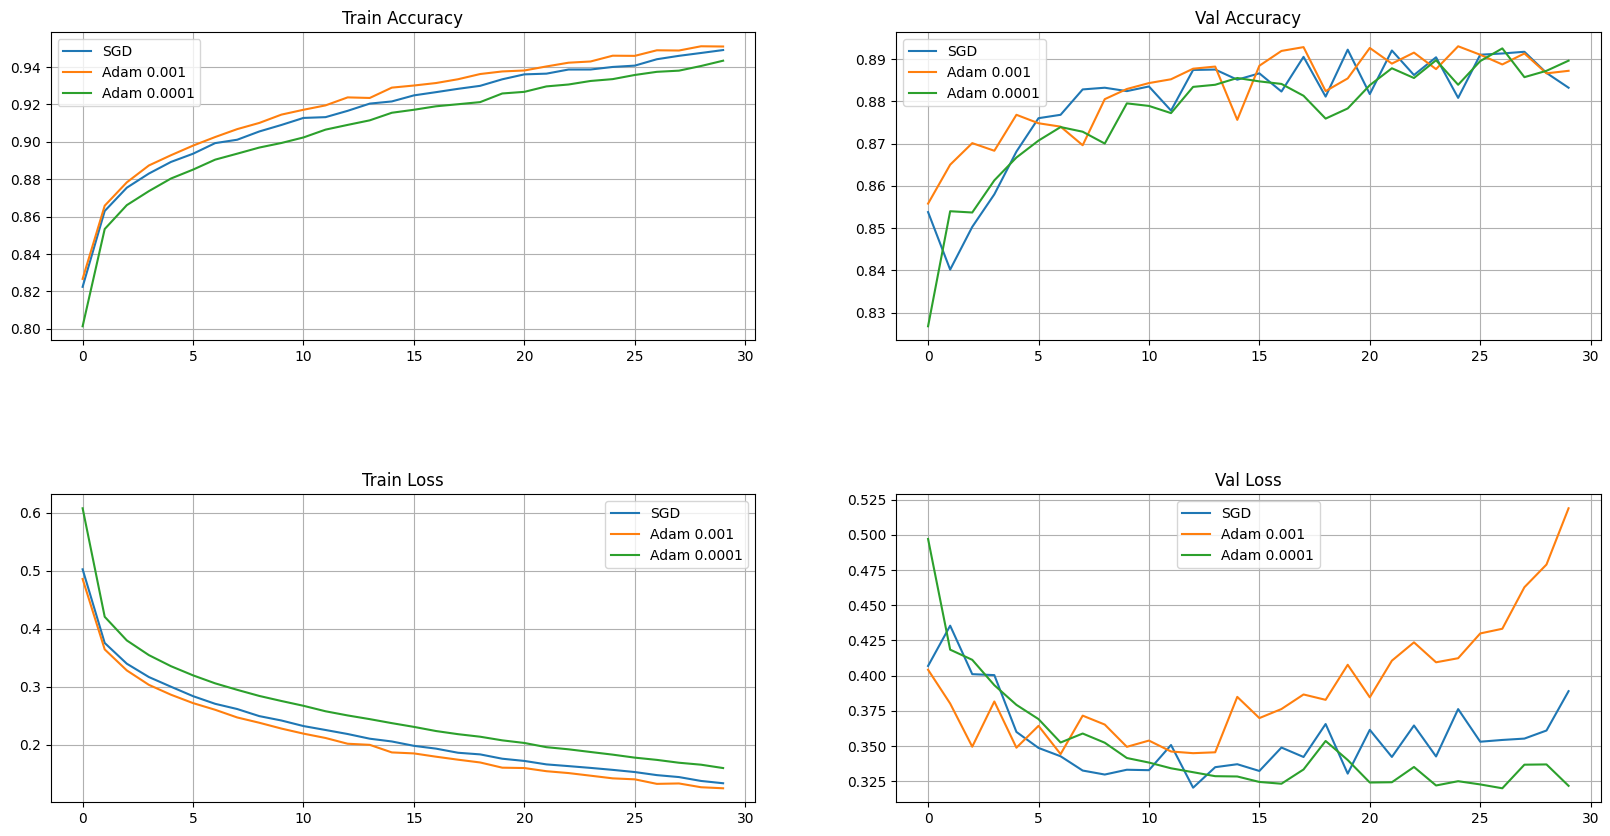

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, (history, _) in enumerate(models_history):
    axs[0][0].plot(history.history['accuracy'], label=f'{optimizers_names[i]}')
    axs[0][1].plot(history.history['val_accuracy'], label=f'{optimizers_names[i]}')
    axs[1][0].plot(history.history['loss'], label=f'{optimizers_names[i]}')
    axs[1][1].plot(history.history['val_loss'], label=f'{optimizers_names[i]}')

axs[0][0].set_title('Train Accuracy')
axs[0][1].set_title('Val Accuracy')
axs[1][0].set_title('Train Loss')
axs[1][1].set_title('Val Loss')

for ax in axs.flatten():
    ax.legend()
    ax.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()